# Data classification

Data classification is a common task in geospatial data analysis that determines the assignment of values to distinct classes.
Classifying original values into categories may help simplify the data for further analysis or communicating the results. Data classification is central when visualizing geographic information to correctly represent the distribution of the data. 

Here, we will get familiar with classification schemes from the [PySAL](https://pysal.org/) [^pysal] [`mapclassify` library](https://pysal.org/mapclassify/) [^mapclassify] that is intended to be used when visualizing thematic maps. Further details of geographic data visualization will be covered in chapter 8. We will also learn how to classify data values based on pre-defined threshold values and conditional statements directly in `geopandas`. 

Our sample data is an extract from the  Helsinki Region Travel Time Matrix ({cite}`Tenkanen2020`) that represents travel times to the central railway station across 250 m x 250 m statistical grid squares covering the Helsinki region. Let's read in the data and check the first rows of data: 

In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = Path("data")
grid_fp = data_dir / "Helsinki" / "TravelTimes_to_5975375_RailwayStation.shp"

# Read files
grid = gpd.read_file(grid_fp)
grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000 6697750, 381750 6697750, 3817..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250 6697750, 382000 6697750, 3820..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500 6697750, 382250 6697750, 3822..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750 6697750, 382500 6697750, 3825..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250 6697500, 381000 6697500, 3810..."


Detailed column descriptions are available in Table 3, {cite}`Tenkanen2020`. We will use column `'pt_r_t'` which contains information about travel time in minutes to the central railway station by public transportation in rush hour traffic. Missing data are presented with value -1. Let's set the missing values as `NaN` to exclude no data from further analysis:

In [2]:
grid = grid.replace(-1, np.nan)

## Classification schemes

We will now learn how to use `mapclassify`to assing the data vaules into distinct classes. `Mapclassify` allows applying various classification schemes on our data that partition the attribute values into mutually exclusive groups. Choosing an adequate classification scheme and number of classes depends on the message we want to convey with our map and the underlying distribution of the data. Available classification schemes include: 

- box_plot
- equal_interval
- fisher_jenks
- fisher_jenks_sampled
- headtail_breaks
- jenks_caspall
- jenks_caspall_forced
- jenks_caspall_sampled
- max_p_classifier
- maximum_breaks
- natural_breaks
- quantiles
- percentiles
- std_mean
- user_defined
  
See {cite}`Rey_et_al_2023` for a thorough introduction on the mathematics behind each classification scheme. These classification schemes can be used directly when plotting data in `geopandas` as long as `mapclassify` package is also installed.


### Choosing a classification scheme

Let's have a look at the distribution of the public transport travel times through checking the histogram and descriptive statistics. A histogram is a graphic representation of the distribution of the data. Descriptive statistics summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding `NaN` values. While looking at the histogram, remember that each observation is one 250 meter x 250 meter grid square in the Helsinki region and the histogram shows the distribution of travel times to the central railway station across the whole region. 

For exploring the different classification schemes, let's create a `pandas` `Series` without `NaN` values.

In [3]:
# Creating a data Series withouth NaN values
travel_times = grid.loc[grid["pt_r_t"].notnull(), "pt_r_t"]

<Axes: ylabel='Frequency'>

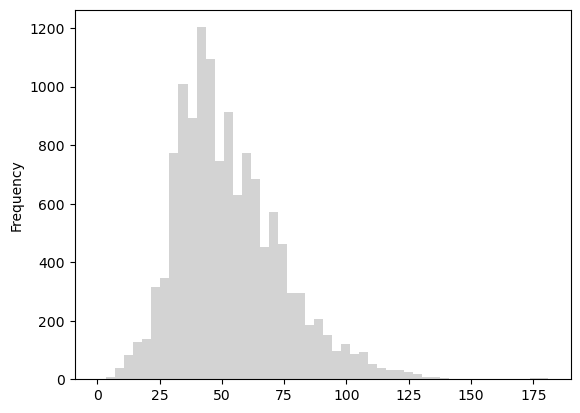

In [4]:
# Plot a histogram
travel_times.plot.hist(bins=50, color="lightgray")

_**Figure 6.60**. Histogram of the travel time values. Data source: Tenkanen & Toivonen 2020._

In [5]:
travel_times.describe()

count    13020.000000
mean        53.124654
std         21.295944
min          0.000000
25%         38.000000
50%         49.000000
75%         65.000000
max        181.000000
Name: pt_r_t, dtype: float64

The maximum travel time to the central railway station by public transport (including time for walking) is 181 minutes, i.e. over three hours. Most of the travel times range between 38 and 65 minutes with an average travel time of 53 minutes. Looking at the histogram (Figure 8.6), we can tell than only a handful of grid squares have more than two hour travel times to the central railway station. These grid squares are most likely located in rather inaccessible places in terms of public transport accessibility. 

Let's have a closer look at how these `mapclassify` classifiers work and try out different classification schemes for visualizing the public transport traveltimes. In the interactive version of this book, you can try out different numbers of classes and different classification schemes.

#### Natural breaks

First, let's try out natural breaks classifier that tries to split the values into natural clusters. The number of observations per bin may vary according to the distribution of the data.

In [6]:
import mapclassify

mapclassify.NaturalBreaks(y=travel_times, k=10)

NaturalBreaks

    Interval       Count
------------------------
[  0.00,  24.00] |   604
( 24.00,  34.00] |  1689
( 34.00,  42.00] |  2360
( 42.00,  49.00] |  1885
( 49.00,  58.00] |  1978
( 58.00,  68.00] |  1718
( 68.00,  80.00] |  1412
( 80.00,  94.00] |   756
( 94.00, 113.00] |   456
(113.00, 181.00] |   162

It's possible to extract the threshold values into an array:

In [7]:
mapclassify.NaturalBreaks(y=travel_times, k=10).bins

array([ 22.,  33.,  40.,  48.,  57.,  66.,  76.,  90., 109., 181.])

We can further explore the classification on top of the histogram:

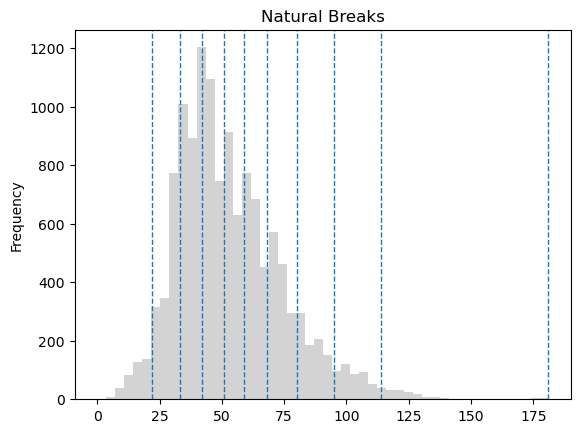

In [8]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.NaturalBreaks(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Natural Breaks")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 6.61**. Histogram of the travel time values with natural breaks classification into 10 groups. Data source: Tenkanen & Toivonen 2020._

We can apply the classifier on our data and store the result in a new column.

In [9]:
# Classify the data
grid["pt_r_t_nb"] = grid[["pt_r_t"]].apply(classifier)
grid["pt_r_t_nb"].head()

0    8
1    8
2    8
3    9
4    8
Name: pt_r_t_nb, dtype: int64

Finally, we can visualize our data using the classification scheme when plotting the data in `geopandas` through adding the `scheme` option, while the parameter `k` defines the number of classess to use. 

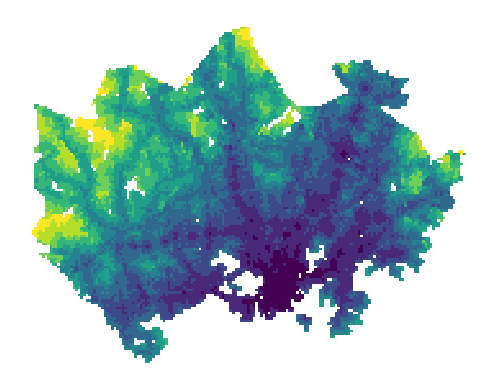

In [10]:
# Plot the data using natural breaks
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    linewidth=0,
    scheme="natural_breaks",
    k=10,
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

_**Figure 6.62**. Travel times visualized using the natural breaks classification scheme. Data source: Tenkanen & Toivonen 2020._

#### Quantiles 

Next, let's explore the quantiles classification that splits the data so that each class has an equal number of observations. 

In [11]:
mapclassify.Quantiles(y=travel_times, k=10)

Quantiles

    Interval       Count
------------------------
[  0.00,  30.00] |  1406
( 30.00,  36.00] |  1436
( 36.00,  40.00] |  1242
( 40.00,  44.00] |  1135
( 44.00,  49.00] |  1319
( 49.00,  55.00] |  1392
( 55.00,  62.00] |  1342
( 62.00,  70.00] |  1265
( 70.00,  81.00] |  1190
( 81.00, 181.00] |  1293

Notice that the numerical range of the groups created using the quantiles classification scheme may vary greatly depending on the distribution of the data. In our example, some classes have more than 30 min interval, while others less than 10 minutes. The default number of classes is five (quintiles), but you can set the desired number of classes using the `k` parameter. In the interactive version of the book, you can try changing the number of classes and see what happens to the class intervals; more classes get added around the central peak of the histogram if increasing the number of classes.

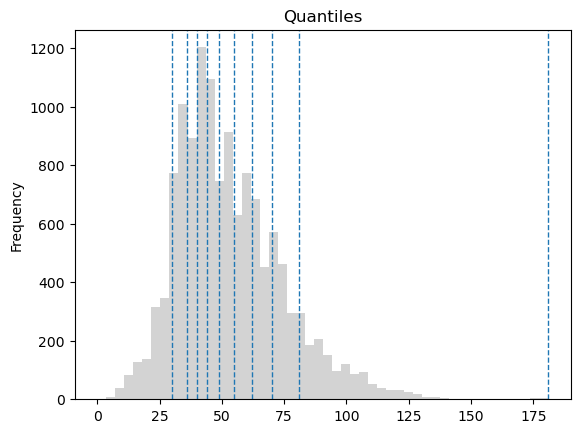

In [12]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.Quantiles(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Quantiles")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 6.63**. Histogram of the travel time values with Quantile classification into 10 groups. Data source: Tenkanen & Toivonen 2020._

If comparing the histograms of natural breaks and quantile classifications, we can observe that natural breaks might work better to display differences in the data values across the whole data range, while quantiles would help distinguishing differences around the central peak of the data distribution. However, neither of the classification schemes display differences in short, less than 25 minute travel times which might be important for making an informative map. Also, we might want to have round numbers for our class values to facilitate quick and intuitive interpretation. 

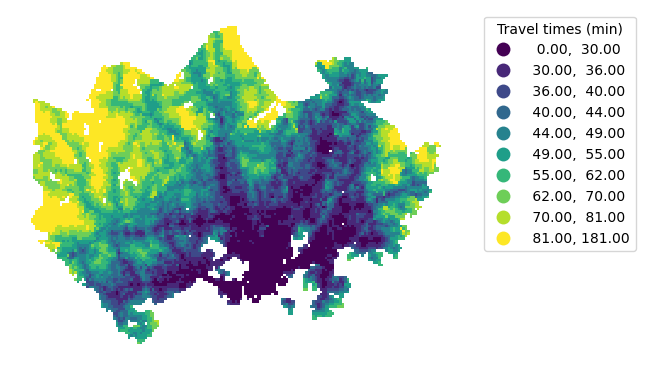

In [13]:
# Plot the data using quantiles
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    linewidth=0,
    scheme="quantiles",
    k=10,
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

_**Figure 6.64**. Static map of travel times visualized using the quantiles classification scheme. Data source: Tenkanen & Toivonen 2020._

In [14]:
# Store the class index numbers 
grid["pt_r_t_q10"] = grid[["pt_r_t"]].apply(classifier)
grid["pt_r_t_q10"].head()

0    9
1    9
2    9
3    9
4    9
Name: pt_r_t_q10, dtype: int64

The quantile classification allows us to extract, for example the best 10 % of all grid squares in terms of travel times to the central railway station. Now that we divided the data into quintiles, we can get the top 10 % of the data through extracting the first category of our classified values. 

In [15]:
grid[grid["pt_r_t_q10"]==0].explore()

_**Figure 6.65**. Top 10 % out of all statistical grid squares in the Helsinki Region in terms of public transport travel times to the Helsinki. Data source: Tenkanen & Toivonen 2020._

#### Pretty breaks

The pretty breaks classification shceme rounds the class break values and divides the range equally to create intervals that look nice and that are easy to read. This classification scheme might be tempting to use as it creates intuitive and visually appealing intervals. However, depending on the distribution of the data, the group sizes might vary greatly which might lead to misleading visualizations.

In [16]:
mapclassify.PrettyBreaks(y=travel_times, k=10)

Pretty

    Interval       Count
------------------------
[  0.00,  20.00] |   335
( 20.00,  40.00] |  3749
( 40.00,  60.00] |  4822
( 60.00,  80.00] |  2740
( 80.00, 100.00] |   933
(100.00, 120.00] |   351
(120.00, 140.00] |    84
(140.00, 160.00] |     0
(160.00, 180.00] |     5
(180.00, 200.00] |     1

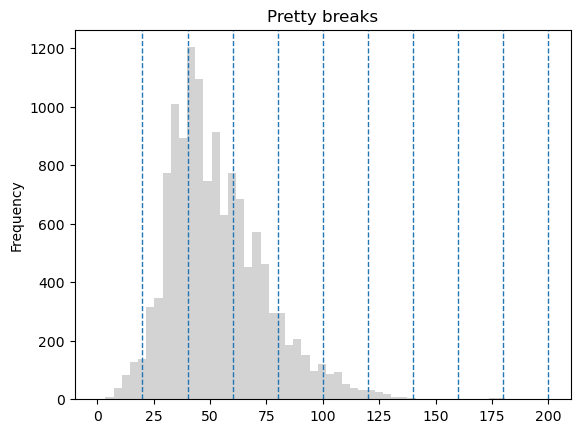

In [17]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.PrettyBreaks(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Pretty breaks")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 6.66**. Histogram of the travel time values with 10 pretty breaks. Data source: Tenkanen & Toivonen 2020._

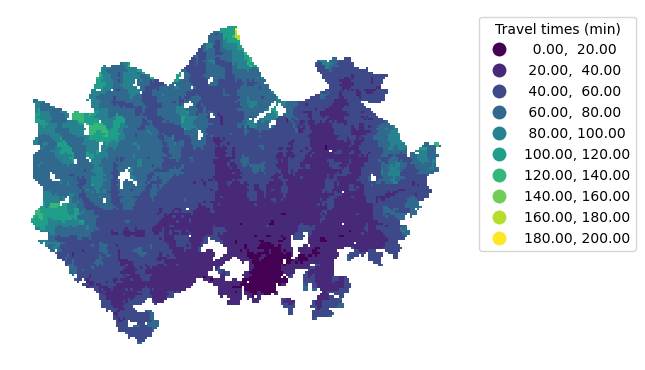

In [18]:
# Plot the data using pretty breaks
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    linewidth=0,
    scheme="prettybreaks",
    k=10,
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

_**Figure 6.67**. Static map of travel times visualized using the pretty breaks classification scheme. Data source: Tenkanen & Toivonen 2020._



Regardless of the number of classes, pretty breaks is not ideal for our data as it fails to capture the variation in the data. Compared to this map, the previous two versions using natural breaks and quantiles provide a more informative view of the travel times.

### Custom map classification

In case none of the existing classification schemes produce a desired output, we can also create a custom classification scheme using `mapclassify` and select which class interval values to use. Fixed intervals with gradually increasing travel times provide an intuitive way to display travel time data. While the pretty breaks classification scheme follows this approach, it didn’t work perfectly for our data. With our own classification scheme, we can show differences among the typical travel times, but avoid having classes distinguishing between long travel times. We'll create a custom classifier with fixed 10-minute intervals up to 90 minutes to achieve this. 

In [19]:
break_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)
classifier

UserDefined

    Interval       Count
------------------------
[  0.00,  10.00] |    49
( 10.00,  20.00] |   286
( 20.00,  30.00] |  1071
( 30.00,  40.00] |  2678
( 40.00,  50.00] |  2697
( 50.00,  60.00] |  2125
( 60.00,  70.00] |  1631
( 70.00,  80.00] |  1109
( 80.00,  90.00] |   603
( 90.00, 181.00] |   771

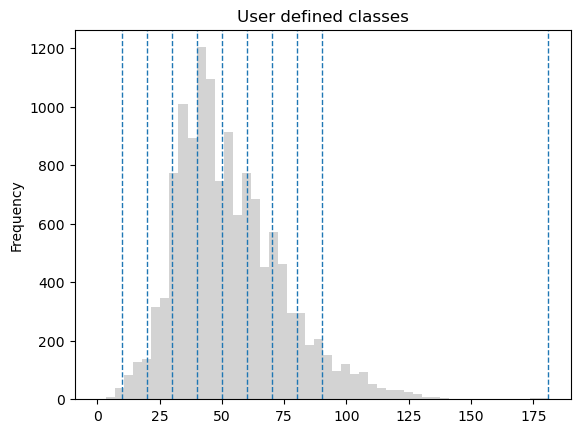

In [20]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, title="User defined classes", color="lightgray")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 6.68**. Histogram of the travel time values with user defined class breaks. Data source: Tenkanen & Toivonen 2020._

When plotting the map, we can pass the break values using `classification_kwds`. 

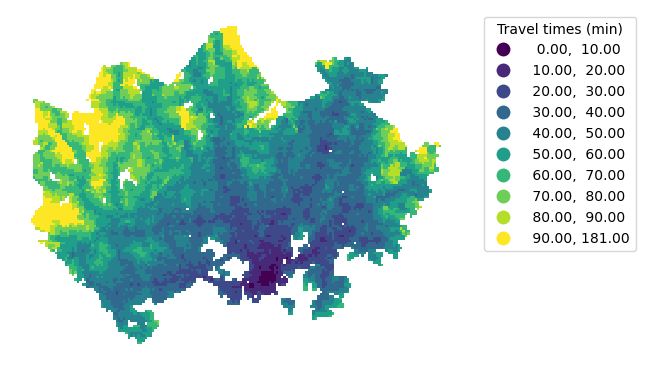

In [21]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

grid.plot(
    ax=ax,
    column="pt_r_t",
    linewidth=0,
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

_**Figure 6.69**. Static map of travel times by car and public transport using a custom classification scheme. Data source: Tenkanen & Toivonen 2020._

#### Question 6.14

Select another column from the data (for example, travel times by car: `car_r_t`) and visualize a thematic map using our custom classification scheme. 

In [22]:
# Use this cell to enter your solution.

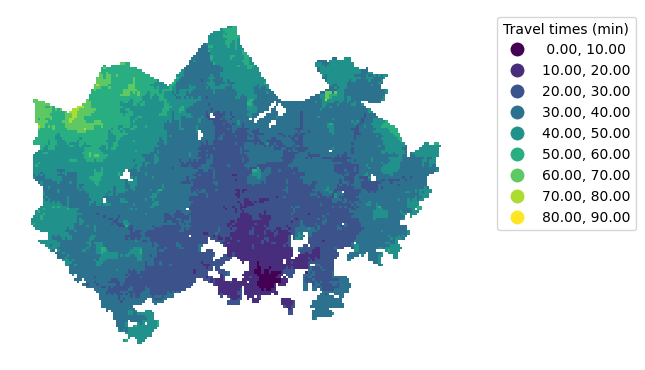

In [23]:
# Solution

# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times using a classification scheme and add a legend
grid.plot(
    ax=ax,
    column="car_r_t",
    linewidth=0,
    scheme="UserDefined",
    classification_kwds={"bins": break_values},
    legend=True,
    legend_kwds={"title": "Travel times (min)", "bbox_to_anchor": (1.4, 1)},
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

## Rule-based classification

Sometimes our analysis task benefits from combining multiple criteria for classifying data. For example, we might want to find out locations that are outside the city center within a reasonable public transport travel time. Such a selection could help us classify the statistical grid squares based on the potential for finding apartments with good public transport connections while avoiding the most expensive areas in the city center.

To implement this, we can use conditional statements to find grid squares where public transport travel time (column `pt_r_tt`) is less than a selected threshold value in minutes, and where walking distance (`walk_d`) is more than a selected threshold value in meters. Each rule will give a binary result (`True`/`False`) and we can further combine these rules to find those locations that meet both requirements.

In [24]:
# Threhsold values
pt_maximum = 30
walk_minimum = 2500

In [25]:
grid["pt_r_tt"] < pt_maximum

0        False
1        False
2        False
3        False
4        False
         ...  
13226    False
13227    False
13228    False
13229    False
13230    False
Name: pt_r_tt, Length: 13231, dtype: bool

In [26]:
grid["walk_d"] > walk_minimum

0         True
1         True
2         True
3         True
4         True
         ...  
13226     True
13227     True
13228    False
13229     True
13230     True
Name: walk_d, Length: 13231, dtype: bool

We can then use our `pandas` skills to combine these rules. Notice that you need parentheses around each set of condition.

In [27]:
grid["rule1"] = (grid["pt_r_tt"] < pt_maximum) & (grid["walk_d"] > walk_minimum)

Finally, now that we have our rule-based classification stored in one of our `GeoDataFrame`columns, we can use this information to visualize the areas that meet our criteria:

In [28]:
grid.loc[grid["rule1"]==True].explore()

_**Figure 6.70**. Grid squares that meet the selection criteria._

#### Question 6.15

Change the threshold values above and see how the map changes!

## Footnotes

[^pysal]: <https://pysal.org/> 
[^mapclassify]: <https://pysal.org/mapclassify/>
